In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform
from matplotlib import markers
import itertools

In [189]:
# finds indices of closest clusters to be merged on next iteration
# clusters_matrix - clusters matrix
# distance_col, cluster_col - ids of columns keeping min distance and closest cluster id
# returns cluster indices and distance between them
def find_clusters_to_merge(clusters_matrix, distance_col, cluster_col):
    # todo write your code here
    min_dist, min_index, target = np.inf, -1, -1
    
    min_index = np.argmin(clusters_matrix[:, distance_col])
    min_dist = clusters_matrix[min_index, distance_col]
    target = clusters_matrix[min_index, cluster_col]
    
    return min_index, target, min_dist


def get_participants(X_matrix):
    ids = {}
    for val in np.unique(X_matrix[:, -1]):
        ids[val] = []
    
    for i in range(X_matrix.shape[0]):
        ids[X_matrix[i, -1]].append(i)
        
    return ids

def get_members(sets, c1, c2):
    sets[c1] = sets[c1] + sets[c2]
    sets[c2] = sets[c1]
    return sets[c1]

def update_clusters(X_matrix, clusters_matrix, members, cluster_id):
    for index in members:
        for subindex in members:
            clusters_matrix[index, subindex] = np.inf
            clusters_matrix[subindex, index] = np.inf

        X_matrix[index, -1] = cluster_id


In [193]:
# performs merge of clusters with indices c1_index, c2_index
# updates single-linkage distances in clusters_matrix
# updates cluster membership column in X_matrix
# c1_index, c2_index - indices of clusters to be merged
# X_matrix - data + cluster membership column
# distance_col, cluster_col - ids of columns keeping min distance and closest cluster id
# distances_matrix - initial pairwise distances matrix, good implementation doesn't need it in this method
def single_link_merge(c1_index, c2_index, X_matrix, clusters_matrix, distance_col, cluster_col, distances_matrix, sets):
#     print("c1 = {} c2 = {}, merge distance = {}".format(c1_index, c2_index, clusters_matrix[c1_index, distance_col]))
    c1 = int(c1_index)
    c2 = int(c2_index)
    
    members_c1 = get_members(sets, c1, c2)
    update_clusters(X_matrix, clusters_matrix, members_c1, c1)
    
#     print(members_c1)
    
    
    
    minmin, minindex = np.inf, -1
    
    for (cluster_id, ids) in sets.items():
        if cluster_id not in members_c1:
            new_min = np.inf
            for i in ids:
                for j in members_c1:
#                     val = clusters_matrix[i, j]  # leads to another result
                    val = distances_matrix[i, j]

                    if val < new_min:
                        new_min = val
                        if minmin > new_min:
                                minmin = new_min
                                minindex = cluster_id
            
            for i in ids:
                for j in members_c1:
                    clusters_matrix[i, j] = new_min
                    clusters_matrix[j, i] = new_min
                        
                    
                            
            if new_min < clusters_matrix[cluster_id, distance_col]:
                clusters_matrix[cluster_id, distance_col] = new_min
                clusters_matrix[cluster_id, cluster_col] = c1
    
    for index in members_c1:
        clusters_matrix[index, distance_col] = minmin
        clusters_matrix[index, cluster_col] = minindex
        clusters_matrix[index, distance_col] = minmin
        clusters_matrix[index, cluster_col] = minindex    

In [199]:
# performs merge of clusters with indices c1_index, c2_index
# updates complete-linkage distances in clusters_matrix
# updates cluster membership column in X_matrix
# c1_index, c2_index - indices of clusters to be merged
# X_matrix - data + cluster membership column
# distance_col, cluster_col - ids of columns keeping min distance and closest cluster id
# distances_matrix - initial pairwise distances matrix, good implementation doesn't need it in this method
def complete_link_merge(c1_index, c2_index, X_matrix, clusters_matrix, distance_col, cluster_col, distances_matrix, sets):
    #     print("c1 = {} c2 = {}, merge distance = {}".format(c1_index, c2_index, clusters_matrix[c1_index, distance_col]))
    c1 = int(c1_index)
    c2 = int(c2_index)
    
    members_c1 = get_members(sets, c1, c2)
    update_clusters(X_matrix, clusters_matrix, members_c1, c1)
    
#     print(members_c1)
    
    
    
    maxmax, maxindex = 0, -1
    
    for (cluster_id, ids) in sets.items():
        if cluster_id not in members_c1:
            new_max = 0
            for i in ids:
                for j in members_c1:
#                     val = clusters_matrix[i, j]  # leads to another result
                    val = distances_matrix[i, j]

                    if val > new_max:
                        new_max = val
                        if maxmax < new_max:
                                maxmax = new_max
                                maxindex = cluster_id
            
            for i in ids:
                for j in members_c1:
                    clusters_matrix[i, j] = new_max
                    clusters_matrix[j, i] = new_max
                        
                    
                            
            if new_max < clusters_matrix[cluster_id, distance_col]:
                clusters_matrix[cluster_id, distance_col] = new_max
                clusters_matrix[cluster_id, cluster_col] = c1
    
    for index in members_c1:
        clusters_matrix[index, distance_col] = maxmax
        clusters_matrix[index, cluster_col] = maxindex
        clusters_matrix[index, distance_col] = maxmax
        clusters_matrix[index, cluster_col] = maxindex    


In [209]:
# performs merge of clusters with indices c1_index, c2_index
# updates average-linkage distances in clusters_matrix
# updates cluster membership column in X_matrix
# c1_index, c2_index - indices of clusters to be merged
# X_matrix - data + cluster membership column
# distance_col, cluster_col - ids of columns keeping min distance and closest cluster id
# distances_matrix - initial pairwise distances matrix, use it for this method
def average_link_merge(c1_index, c2_index, X_matrix, clusters_matrix, distance_col, cluster_col, distances_matrix, sets):
    #     print("c1 = {} c2 = {}, merge distance = {}".format(c1_index, c2_index, clusters_matrix[c1_index, distance_col]))
    c1 = int(c1_index)
    c2 = int(c2_index)
    
    members_c1 = get_members(sets, c1, c2)
    update_clusters(X_matrix, clusters_matrix, members_c1, c1)
    
#     print(members_c1)
    
    
    
    gl_avg, avgindex = np.inf, -1
    
    for (cluster_id, ids) in sets.items():
        if cluster_id not in members_c1:
            new_avg = 0
            for i in ids:
                for j in members_c1:
#                     val = clusters_matrix[i, j]  # leads to another result
                    val = distances_matrix[i, j]
                    new_avg += val
            
            new_avg /= (1.0 * len(ids) * len(members_c1))
            if new_avg < gl_avg:
                gl_avg = new_avg
                avgindex = cluster_id
            
            for i in ids:
                for j in members_c1:
                    clusters_matrix[i, j] = new_avg
                    clusters_matrix[j, i] = new_avg
                        
                    
                            
            if new_avg < clusters_matrix[cluster_id, distance_col]:
                clusters_matrix[cluster_id, distance_col] = new_avg
                clusters_matrix[cluster_id, cluster_col] = c1
    
    for index in members_c1:
        clusters_matrix[index, distance_col] = gl_avg
        clusters_matrix[index, cluster_col] = avgindex
        clusters_matrix[index, distance_col] = gl_avg
        clusters_matrix[index, cluster_col] = avgindex    

Merging clusters # 48 49.0


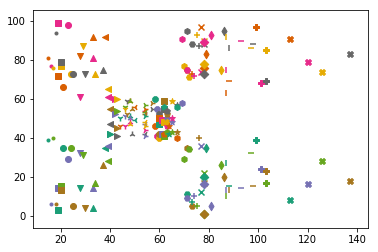

Merging clusters # 65 68.0
Merging clusters # 129 131.0
Merging clusters # 156 158.0
Merging clusters # 21 23.0
Merging clusters # 51 53.0
Merging clusters # 60 61.0
Merging clusters # 63 65.0
Merging clusters # 64 66.0
Merging clusters # 67 69.0
Merging clusters # 74 77.0
Merging clusters # 75 76.0
Merging clusters # 78 76.0
Merging clusters # 79 82.0
Merging clusters # 80 78.0
Merging clusters # 81 75.0
Merging clusters # 85 74.0
Merging clusters # 92 97.0
Merging clusters # 94 98.0
Merging clusters # 99 92.0
Merging clusters # 100 105.0
Merging clusters # 101 109.0
Merging clusters # 103 104.0
Merging clusters # 107 113.0
Merging clusters # 119 120.0
Merging clusters # 149 155.0
Merging clusters # 150 154.0
Merging clusters # 151 155.0
Merging clusters # 170 174.0
Merging clusters # 3 5.0
Merging clusters # 10 12.0


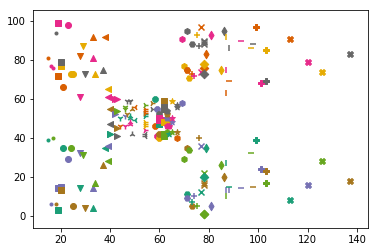

Merging clusters # 14 10.0
Merging clusters # 26 28.0
Merging clusters # 40 42.0
Merging clusters # 54 57.0
Merging clusters # 58 62.0
Merging clusters # 70 73.0
Merging clusters # 91 93.0
Merging clusters # 108 105.0
Merging clusters # 111 103.0
Merging clusters # 112 108.0
Merging clusters # 116 112.0
Merging clusters # 126 132.0
Merging clusters # 137 139.0
Merging clusters # 147 159.0
Merging clusters # 94 105.0
Merging clusters # 64 62.0
Merging clusters # 91 94.0
Merging clusters # 2 6.0
Merging clusters # 13 15.0
Merging clusters # 59 57.0
Merging clusters # 83 79.0
Merging clusters # 84 81.0
Merging clusters # 87 90.0
Merging clusters # 95 97.0
Merging clusters # 96 92.0
Merging clusters # 106 109.0
Merging clusters # 110 106.0
Merging clusters # 114 109.0
Merging clusters # 115 106.0
Merging clusters # 118 116.0


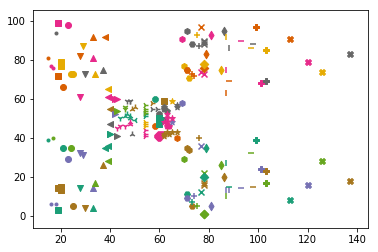

Merging clusters # 128 130.0
Merging clusters # 134 136.0
Merging clusters # 140 134.0
Merging clusters # 148 152.0
Merging clusters # 153 157.0
Merging clusters # 165 171.0
Merging clusters # 176 174.0
Merging clusters # 0 4.0
Merging clusters # 50 52.0
Merging clusters # 56 58.0
Merging clusters # 72 66.0
Merging clusters # 86 88.0
Merging clusters # 89 96.0
Merging clusters # 122 119.0
Merging clusters # 125 129.0
Merging clusters # 133 137.0
Merging clusters # 143 151.0
Merging clusters # 146 160.0
Merging clusters # 164 168.0
Merging clusters # 181 183.0
Merging clusters # 186 190.0
Merging clusters # 187 191.0
Merging clusters # 107 101.0
Merging clusters # 78 81.0
Merging clusters # 67 59.0
Merging clusters # 114 115.0
Merging clusters # 147 153.0
Merging clusters # 56 66.0
Merging clusters # 38 44.0
Merging clusters # 117 119.0


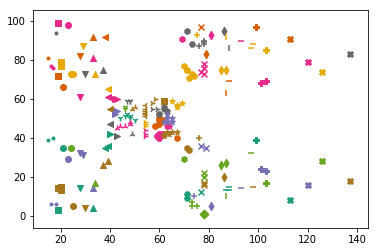

Merging clusters # 16 20.0
Merging clusters # 30 32.0
Merging clusters # 74 83.0
Merging clusters # 102 104.0
Merging clusters # 121 118.0
Merging clusters # 172 170.0
Merging clusters # 89 101.0
Merging clusters # 60 70.0
Merging clusters # 111 110.0
Merging clusters # 8 6.0
Merging clusters # 34 36.0
Merging clusters # 43 51.0
Merging clusters # 46 52.0
Merging clusters # 48 55.0
Merging clusters # 128 138.0
Merging clusters # 135 143.0
Merging clusters # 167 173.0
Merging clusters # 95 106.0
Merging clusters # 114 99.0
Merging clusters # 87 86.0
Merging clusters # 98 118.0
Merging clusters # 150 152.0
Merging clusters # 3 13.0
Merging clusters # 37 39.0
Merging clusters # 47 54.0
Merging clusters # 144 138.0
Merging clusters # 56 69.0
Merging clusters # 92 113.0
Merging clusters # 92 109.0
Merging clusters # 115 92.0


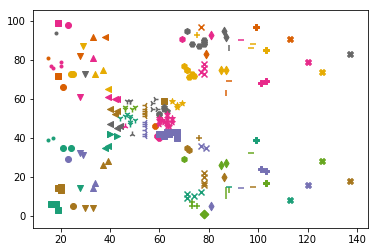

Merging clusters # 131 133.0
Merging clusters # 176 172.0
Merging clusters # 63 73.0
Merging clusters # 61 63.0
Merging clusters # 31 37.0
Merging clusters # 45 43.0
Merging clusters # 1 3.0
Merging clusters # 11 19.0
Merging clusters # 142 146.0
Merging clusters # 141 149.0
Merging clusters # 163 149.0
Merging clusters # 125 137.0
Merging clusters # 103 95.0
Merging clusters # 136 128.0
Merging clusters # 140 138.0
Merging clusters # 93 98.0
Merging clusters # 9 5.0
Merging clusters # 123 127.0
Merging clusters # 145 141.0
Merging clusters # 75 87.0
Merging clusters # 78 87.0
Merging clusters # 102 87.0
Merging clusters # 3 15.0
Merging clusters # 9 15.0
Merging clusters # 48 54.0
Merging clusters # 59 66.0
Merging clusters # 46 61.0
Merging clusters # 24 34.0
Merging clusters # 33 41.0
Merging clusters # 71 59.0


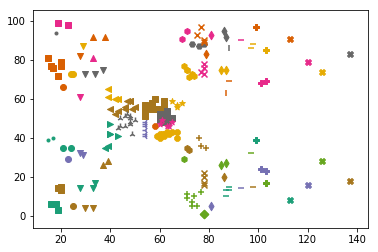

Merging clusters # 156 140.0
Merging clusters # 161 143.0
Merging clusters # 162 156.0
Merging clusters # 7 11.0
Merging clusters # 22 30.0
Merging clusters # 25 29.0
Merging clusters # 35 25.0
Merging clusters # 178 174.0
Merging clusters # 182 178.0
Merging clusters # 120 102.0
Merging clusters # 117 102.0
Merging clusters # 147 139.0
Merging clusters # 124 132.0
Merging clusters # 166 176.0
Merging clusters # 179 183.0
Merging clusters # 188 182.0
Merging clusters # 21 31.0
Merging clusters # 26 20.0
Merging clusters # 167 163.0
Merging clusters # 18 26.0
Merging clusters # 189 183.0
Merging clusters # 91 107.0
Merging clusters # 91 96.0
Merging clusters # 112 107.0
Merging clusters # 118 107.0
Merging clusters # 125 159.0
Merging clusters # 169 177.0
Merging clusters # 175 173.0
Merging clusters # 95 90.0
Merging clusters # 74 71.0


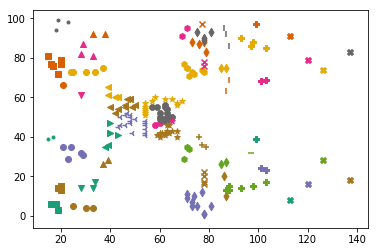

Merging clusters # 46 58.0
Merging clusters # 17 9.0
Merging clusters # 153 129.0
Merging clusters # 53 46.0
Merging clusters # 165 177.0
Merging clusters # 133 157.0
Merging clusters # 72 46.0
Merging clusters # 164 166.0
Merging clusters # 114 103.0
Merging clusters # 186 188.0
Merging clusters # 40 48.0
Merging clusters # 142 126.0
Merging clusters # 0 16.0
Merging clusters # 148 144.0
Merging clusters # 128 154.0
Merging clusters # 144 154.0
Merging clusters # 180 184.0
Merging clusters # 2 22.0


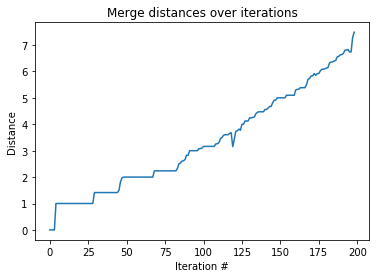

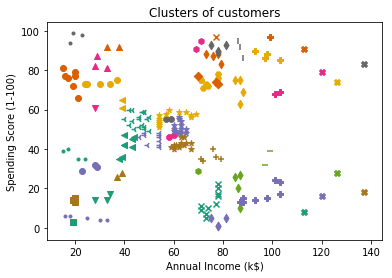

In [215]:

# performing bottom-up clustering with three different linkage functions
# todo set your own thresholds for each method.
# todo find thresholds by looking at plot titled "Merge distances over iterations" when threshold is set to None
# bottom_up_clustering(single_link_merge, X, distances, threshold=None)
# bottom_up_clustering(complete_link_merge, X, distances, threshold=None)
bottom_up_clustering(average_link_merge, X, distances, threshold=None)

In [212]:
# the function which performs bottom-up (agglomerative) clustering
# merge_func - one of the three merge functions above, each with different linkage function
# X_matrix - data itself
# threshold - maximum merge distance, we stop merging if we reached it. if None, merge until there only is one cluster
def bottom_up_clustering(merge_func, X_matrix, distances_matrix, threshold=None):
    num_points = X_matrix.shape[0]

    # take dataset, add and initialize column for cluster membership
    X_data = np.c_[X_matrix, np.arange(0, num_points, 1)]

    # create clusters matrix, initially consisting of all points and pairwise distances
    # with last columns being distance to closest cluster and id of that cluster
    clusters = np.c_[distances_matrix, np.zeros((num_points, 2))]

    # ids of added columns - column with minimal distances, column with closest cluster ids
    dist_col_id = num_points
    clust_col_id = num_points + 1

    # calculate closest clusters and corresponding distances for each cluster
    clusters[:, clust_col_id] = np.argmin(clusters[:, :num_points], axis=1)
    clusters[:, dist_col_id] = np.amin(clusters[:, :num_points], axis=1)

    # array for keeping distances between clusters that we are merging
    merge_distances = np.zeros(num_points - 1)
    
    # My variable
    sets = get_participants(X_data)
    # main loop. at each step we are identifying and merging two closest clusters (wrt linkage function)
    for i in range(0, num_points - 1):
        c1_id, c2_id, distance = find_clusters_to_merge(clusters, dist_col_id, clust_col_id)
        # if threshold is set, we don't merge any further if we reached the desired max distance for merging
        if threshold is not None and distance > threshold:
            break
        merge_distances[i] = distance
        merge_func(c1_id, c2_id, X_data, clusters, dist_col_id, clust_col_id, distances_matrix, sets)
#         break
        # uncomment when testing
        print("Merging clusters #", c1_id, c2_id)
        if i%30 == 0:
            for k, (marker, color) in zip(range(num_points), itertools.product(markerss, colormap)):
                plt.scatter(X_data[X_data[:, 2] == k, 0], X_data[X_data[:, 2] == k, 1], color=color, marker=marker, label=k)
            plt.show()

    # todo use the plot below to find the optimal threshold to stop merging clusters
    plt.plot(np.arange(0, num_points - 1, 1), merge_distances[:num_points - 1])
    plt.title("Merge distances over iterations")
    plt.xlabel("Iteration #")
    plt.ylabel("Distance")
    plt.show()

    for k, (marker, color) in zip(range(num_points), itertools.product(markerss, colormap)):
        plt.scatter(X_data[X_data[:, 2] == k, 0], X_data[X_data[:, 2] == k, 1], color=color, marker=marker)
    plt.title('Clusters of customers')
    plt.xlabel('Annual Income (k$)')
    plt.ylabel('Spending Score (1-100)')
    plt.show()




In [107]:
# importing the dataset
dataset = pd.read_csv('datasets/Mall_Customers.csv')
X = dataset.iloc[:, [3, 4]].values

# creating and populating matrix for storing pairwise distances
# diagonal elements are filled with np.inf to ease further processing
distances = squareform(pdist(X, metric='euclidean'))
np.fill_diagonal(distances, np.inf)

# seting up colors and marker types to use for plotting
markerss = markers.MarkerStyle.markers
colormap = plt.cm.Dark2.colors


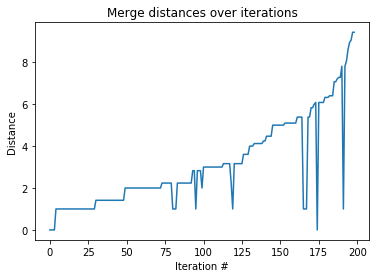

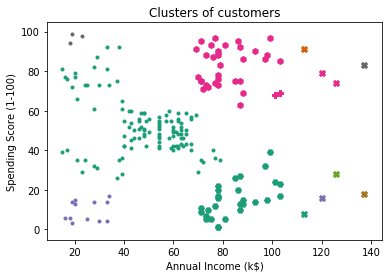

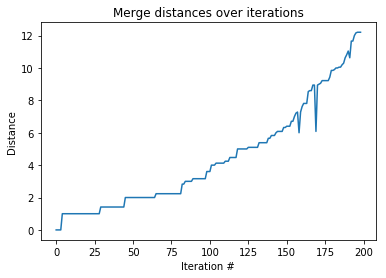

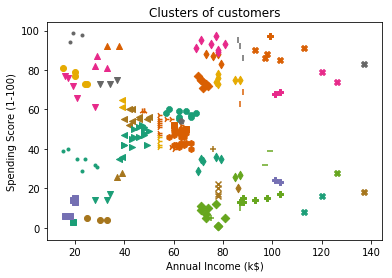

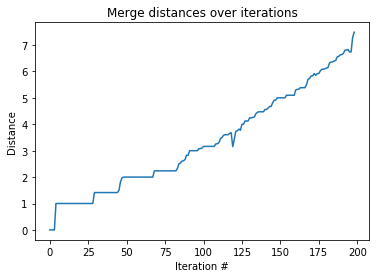

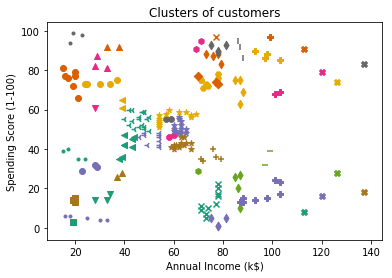

In [211]:

# performing bottom-up clustering with three different linkage functions
# todo set your own thresholds for each method.
# todo find thresholds by looking at plot titled "Merge distances over iterations" when threshold is set to None
bottom_up_clustering(single_link_merge, X, distances, threshold=None)
bottom_up_clustering(complete_link_merge, X, distances, threshold=None)
bottom_up_clustering(average_link_merge, X, distances, threshold=None)

In [159]:
?np.amin

In [160]:
?np.argmin